In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math
import random as rd
import scipy.integrate as integrate
import scipy as sp

In [2]:
# Practice coding section: 
wrest_data = pd.concat([pd.DataFrame(pd.read_csv('ncaa_d1_2019_season_results.csv',sep = ',')), pd.DataFrame(pd.read_csv('ncaa_d1_2018_season_results.csv',sep = ','))], axis = 0).copy()
wrest_data.head(5)

,wrestler,opponent,school,date,event,weight,w_l,by,how,season,...,rt_w,nf_w,re_w,pe_w,td_o,es_o,rt_o,nf_o,re_o,pe_o
0,"#1 Joseph, Vincenzo (27 - 2)","#69 DeLong, Evan (16 - 15)",#64 Clarion,21-Mar,NCAA Championships,165,W,FALL,2:58,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"#1 Joseph, Vincenzo (27 - 2)","#22 Flynn, Connor (21 - 9)",#6 Missouri,21-Mar,NCAA Championships,165,W,DEC,4-Aug,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"#1 Joseph, Vincenzo (27 - 2)","#7 White, Isaiah (25 - 9)",#11 Nebraska,21-Mar,NCAA Championships,165,W,SV-1,1-Mar,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"#1 Joseph, Vincenzo (27 - 2)","#6 Shields, Josh (31 - 6)",#21 Arizona State,21-Mar,NCAA Championships,165,W,DEC,2-Mar,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"#1 Joseph, Vincenzo (27 - 2)","#2 Lewis, Mekhi (28 - 2)",#7 Virginia Tech,21-Mar,NCAA Championships,165,L,DEC,1-Jul,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
wrest_data = pd.concat([pd.DataFrame(pd.read_csv('ncaa_d1_2019_season_results.csv',sep = ',')), pd.DataFrame(pd.read_csv('ncaa_d1_2018_season_results.csv',sep = ','))], axis = 0)

# for the first column wrestler, we are going to break each piece into a separate column, then delete the excess columns
wrestler = wrest_data['wrestler'].str.replace("TakedownLive\sMatch\sData\s","")
wrestler = wrestler.str.replace("\s\(",", ").str.replace("\(",", ").str.replace("\)","").str.replace('\s-\s',', ').str.replace('(?=\D)#','').str.split(',\s|(?<=\d)(?=\D)\s',expand = True) # done in regex
match = wrestler[4].isna()
wrestler.loc[match,4] = wrestler.loc[match,3].to_numpy().copy() # these shift all the data for those wrestlers that were not ranked over so that their names appear in the correct column
wrestler.loc[match,3] = wrestler.loc[match,2].to_numpy().copy()
wrestler.loc[match,2] = wrestler.loc[match,1].to_numpy().copy()
wrestler.loc[match,1] = wrestler.loc[match,0].to_numpy().copy()
wrestler.loc[match,0] = 'NR' # anyone without a number in front of their name is unranked
wrestler['wrest_yr'] = float('nan')
wrestler['wrest_school_rank'] = float('nan')
wrestler['wrest_school'] = float('nan')
wrestler['wrest_conf'] = float('nan')

# Here we are doing the same thing for opponent as for the wrestler column
opponent = wrest_data['opponent'].str.replace("TakedownLive\sMatch\sData\s","")
opponent = opponent.str.replace("\s\(",", ").str.replace("\(",", ").str.replace("\)","").str.replace('\s-\s',', ').str.replace('(?=\D)#','').str.split(',\s|(?<=\d)(?=\D)\s',expand = True)
match = opponent[4].isna()
opponent.loc[match,4] = opponent.loc[match,3].to_numpy().copy()
opponent.loc[match,3] = opponent.loc[match,2].to_numpy().copy()
opponent.loc[match,2] = opponent.loc[match,1].to_numpy().copy()
opponent.loc[match,1] = opponent.loc[match,0].to_numpy().copy()
opponent.loc[match,0] = 'NR'
opponent['opp_yr'] = float('nan')


# the school column needs to be broken in to school ranking and school name
school = pd.DataFrame(wrest_data['school'].str.split( "#|(?<=\d)\s", expand = True)) # (?<=\d)\s  means to only split a space (\s) if it is preceeded by a number (\d)
school.loc[(school[1].isna() & school[2].isna()), 2] = school.loc[(school[1].isna() & school[2].isna()), 0]
school = school.drop(columns = [0])
school['opp_conf'] = float('nan')



# Here we are switching out the month abbreviations in the "how" column with their respective numeric value, but these are still in string form
how = wrest_data['how']
nm_conv = [('Jan','1'),('Feb','2'),('Mar','3'),('Apr','4'),('May','5'),('Jun','6'),('Jul','7'), ('Aug','8'),('Sep','9'),('Oct','10'),('Nov','11'),('Dec','12')]
for a, b in nm_conv:
    how = how.str.replace(a, b)
    
# Now that the months have been switched, we can split up the numbers in to their own columns
how = how.str.split('-|\s-\s|(?<=\d)\s', expand = True)

# FALLs make this tricky because there is no score recorded, so for every FALL in the "by" column we are going to move the time to the last column in the "how" dataframe
how.loc[ wrest_data['by'] =='FALL', 2 ] = how.loc[ wrest_data['by'] == 'FALL', 0 ]
how.loc[ wrest_data['by'] =='FALL', 0 ] = None

# we are going to first convert the string times to a date time format, then subtrack from the default date value to get the time at which the match terminated, then we convert that over to secondsand change it to float
how[2] =  (pd.to_datetime(how[2], format = '%M:%S', errors = 'coerce') - pd.to_datetime('1900-01-01')).dt.total_seconds().apply(pd.to_numeric,errors = 'coerce')      

# add year into "date" category and convert it to datetime format
wrest_data['season'] = wrest_data['season'].apply(pd.to_numeric,errors = 'coerce')
wrest_data['season_2'] = wrest_data['season'].copy()
match = (wrest_data['date'].str.find('Sep') != -1) | (wrest_data['date'].str.find('Oct') != -1) |  (wrest_data['date'].str.find('Nov') != -1) | (wrest_data['date'].str.find('Dec') != -1) 
wrest_data.loc[match,'season'] = (wrest_data.loc[match,'season'] - 1).apply(str)
date = wrest_data['date'].apply(str) + "-"+ wrest_data['season'].apply(str)
#wrest_data = wrest_data.drop(columns = 'season')
wrest_data['season'] = wrest_data['season_2'].copy()
date = pd.to_datetime(date,format = '%d-%b-%Y', errors = 'coerce')

# change "time" to be in that format and get rid of the "none" values

match_dual = wrest_data['event'].str.contains('Dual') | wrest_data['event'].str.contains('dual')
wrest_data.loc[match_dual,'event_type'] = 'D'
wrest_data['event_type'] = wrest_data['event_type'].fillna('T')




# now that we have our data cleaned, lets import all the various dataframes into one big one and add some lables
adj_wrest_data = pd.concat([wrestler, opponent, school, date, wrest_data['season'], wrest_data['event'],wrest_data['event_type'],wrest_data['weight'],wrest_data['w_l'],wrest_data['by'], how], axis = 1, sort = False)
adj_wrest_data.columns = ['wrest_rank','wrest_ln','wrest_fn','wrest_win','wrest_loss',
                          'wrest_yr','wrest_school_rank','wrest_school', 'wrest_conf',
                          'opp_rank', 'opp_ln', 'opp_fn','opp_win','opp_loss',
                          'opp_yr','opp_school_rank','opp_school', 'opp_conf',
                          'date','season', 'event','event_type','weight','w_l','by',
                          'loser_pts','winner_pts','time']

# Also, we need to turn the strings into float so we can do some math. I cant figure out how to switch them to integers so this will have to do
int_col = ['wrest_rank','wrest_win','wrest_loss','opp_rank','opp_win','opp_loss','loser_pts','winner_pts','time']


# ----- one way of converting strings to float
#for a in int_col:
    #adj_wrest_data[a] = pd.to_numeric(adj_wrest_data[a], errors = 'coerce', downcast = 'signed')

# ---- Another way of converting strings to float
adj_wrest_data[int_col] = adj_wrest_data[int_col].apply(pd.to_numeric , axis = 1 , errors = 'coerce')

# reset the index
adj_wrest_data = adj_wrest_data.reset_index(drop = True)

## -----  adds in weather the meet is home or away, labels tournaments 'T'
dual_loc = adj_wrest_data.loc[(adj_wrest_data['event_type'] == 'D'),'event'].str.split(' - ',expand = True)
home_dual = (dual_loc[0] == adj_wrest_data.loc[(adj_wrest_data['event_type'] == 'D'),'opp_school'])
adj_wrest_data.loc[(adj_wrest_data['event_type'] == 'D') & home_dual,'loc'] = 'h'
adj_wrest_data.loc[(adj_wrest_data['event_type'] == 'D') & np.invert(home_dual),'loc'] = 'a'
adj_wrest_data['loc'] = adj_wrest_data['loc'].fillna('t')

# Here we are going to make sure that the loser points are lower than the winner points
match_l = (adj_wrest_data['w_l'] == 'L')
match_pts = adj_wrest_data['winner_pts'] < adj_wrest_data['loser_pts']

temp_wrest = adj_wrest_data.loc[match_l,'wrest_rank':'wrest_school']
temp_opp = adj_wrest_data.loc[match_l,'opp_rank':'opp_school']
temp_win_pts = adj_wrest_data.loc[match_pts,'winner_pts']
temp_los_pts = adj_wrest_data.loc[match_pts,'loser_pts']

adj_wrest_data.loc[match_l,'wrest_rank':'wrest_school'] = temp_opp.to_numpy()
adj_wrest_data.loc[match_l,'opp_rank':'opp_school'] = temp_wrest.to_numpy()
adj_wrest_data.loc[match_l,'loc'] = adj_wrest_data.loc[match_l,'loc'].replace({'a':'H','h':'A'})
adj_wrest_data.loc[match_pts,'winner_pts'] = temp_los_pts.to_numpy()
adj_wrest_data.loc[match_pts,'loser_pts']  = temp_win_pts.to_numpy()

adj_wrest_data = adj_wrest_data.drop(columns = ['w_l'])

#The overall goal here is to get rid of any repeat matches, which occur because the opponent and the wrestler were looked up separately
 
#now lets drop all those none rows
cln_wrest_data = adj_wrest_data.dropna(how = 'all', axis = 0).reset_index(drop = True) 


cln_wrest_data['loc'] = cln_wrest_data['loc'].replace({'a':'A','h':'H','t':'T'})

# i decided that I want the last name and the first name combined
cln_wrest_data['wrest_ln'] = cln_wrest_data['wrest_fn']+ " " + cln_wrest_data['wrest_ln']
cln_wrest_data = cln_wrest_data.rename(columns = {'wrest_ln':'wrest_name'}).drop('wrest_fn', axis = 1)

cln_wrest_data['opp_ln'] = cln_wrest_data['opp_fn']+ " " + cln_wrest_data['opp_ln']
cln_wrest_data = cln_wrest_data.rename(columns = {'opp_ln':'opp_name'}).drop('opp_fn', axis = 1)

### this is going to go in and add peoples schools where the data is missing
foo = pd.concat([cln_wrest_data[['opp_name','season','opp_rank']].rename(columns = {'opp_name':'name','opp_rank':'rank'}),cln_wrest_data[['wrest_name','season','wrest_rank']].rename(columns = {'wrest_name':'name','wrest_rank':'rank'})],axis = 0,ignore_index = True).drop_duplicates().reset_index(drop = True)
foo['school'] = float('nan')
foo_index = foo.index.to_numpy()

#The overall goal here is to get rid of any repeat matches, which occur because the opponent and the wrestler were looked up separately
for i in foo_index:

    match_w = (cln_wrest_data['wrest_name'] == foo.loc[i,'name']) & (cln_wrest_data['season'] == foo.loc[i,'season'])  & (cln_wrest_data['wrest_rank'] == foo.loc[i,'rank'])
    match_o = (cln_wrest_data['opp_name'] == foo.loc[i,'name']) & (cln_wrest_data['season'] == foo.loc[i,'season']) & (cln_wrest_data['opp_rank'] == foo.loc[i,'rank'])
    
    school = pd.concat([cln_wrest_data.loc[match_w,'wrest_school'],cln_wrest_data.loc[match_o,'opp_school']]).dropna().unique() if (len(pd.concat([cln_wrest_data.loc[match_w,'wrest_school'],cln_wrest_data.loc[match_o,'opp_school']]).dropna().unique()) != 0) else float('nan')
    rank  = pd.concat([cln_wrest_data.loc[match_w,'wrest_school_rank'],cln_wrest_data.loc[match_o,'opp_school_rank']]).dropna().unique() if (len(pd.concat([cln_wrest_data.loc[match_w,'wrest_school_rank'],cln_wrest_data.loc[match_o,'opp_school_rank']]).dropna().unique()) != 0) else float('nan')
    
    cln_wrest_data.loc[match_o,'opp_school'] = school
    cln_wrest_data.loc[match_w,'wrest_school'] = school
    cln_wrest_data.loc[match_o,'opp_school_rank'] = rank
    cln_wrest_data.loc[match_w,'wrest_school_rank'] = rank

# print that cleaned data!!!
print("size of data before duplicate drop: ",cln_wrest_data['wrest_name'].size)
match_dup = cln_wrest_data[cln_wrest_data[['wrest_name','wrest_rank','opp_name','opp_rank','date','event','season','by','loser_pts','winner_pts','time']].duplicated(keep = 'first')].index.to_numpy()
cln_wrest_data = cln_wrest_data.drop(match_dup)
print("size of data after duplicate drop: ",cln_wrest_data['wrest_name'].size)

print('size before dropping forfeits: ',len(cln_wrest_data))
match = (cln_wrest_data['by'] == 'MFOR') | (cln_wrest_data['by'] == 'DQ') | (cln_wrest_data['by'] == 'INJ') | (cln_wrest_data['by'] == None) | (cln_wrest_data['by'] == 'FOR')
cln_wrest_data = cln_wrest_data.drop(cln_wrest_data[match].index, axis = 0).reset_index(drop = True)
cln_wrest_data = cln_wrest_data.drop(cln_wrest_data[cln_wrest_data['opp_name'].str.contains('forfeit')].index)
print('size after dropping forfeits: ',len(cln_wrest_data))

#### - put in the match time of decisions, sudden victories, and tie brackers
match_time = pd.Series([420.0,420.0,480.0,540.0,600.0,660.0],index = ['MD','DEC','SV-1','TB-1','SV-2','TB-2'])
cln_wrest_data.loc[cln_wrest_data['time'].isna(),'time'] = match_time[cln_wrest_data.loc[cln_wrest_data['time'].isna(),'by']].to_numpy()

cln_wrest_data['wrest_school'] = cln_wrest_data['wrest_school'].replace({'Unknown':float('nan')})
cln_wrest_data['opp_school'] = cln_wrest_data['opp_school'].replace({'Unknown':float('nan')})

cln_wrest_data.loc[cln_wrest_data['wrest_rank'].isna(),'wrest_rank'] = 500
cln_wrest_data.loc[cln_wrest_data['opp_rank'].isna(),'opp_rank'] = 500
cln_wrest_data.loc[cln_wrest_data['wrest_school_rank'].isna(),'wrest_school_rank'] = 500
cln_wrest_data.loc[cln_wrest_data['opp_school_rank'].isna(),'opp_school_rank'] = 500
cln_wrest_data[['wrest_rank','wrest_school_rank','opp_rank','opp_school_rank']] = cln_wrest_data[['wrest_rank','wrest_school_rank','opp_rank','opp_school_rank']].astype(int)

# the second set of data we are going to use is the wrestler's year in school. This is not given in the origional dataset so it must be added
wrest_info = pd.DataFrame(pd.read_csv('ncaa_d1_19_wrest_info.csv',sep = ','))

df1 = wrest_info['wrest_info'].str.replace('\s\|\s',", ").str.replace('\s-\s',", ").str.split(',\s',expand = True)
df1[0] = df1[1]+' '+df1[0]
df1 = df1.drop(1,axis = 1)
df1.columns = ['wrest_name','wins','losses','year']

df2 = wrest_info['school_info'].str.replace('\s\|\s',", ").str.replace('#',"").str.replace('(?<=\d)\s',", ").str.split(',\s',expand = True)
match = df2[2].isna()
df2.loc[match,2] = df2.loc[match,1].to_numpy().copy()
df2.loc[match,1] = df2.loc[match,0].to_numpy().copy()
df2.loc[match,0] =500
df2.columns = ['school_rank','school','conference'] #df2.columns = []

wrest_info = pd.DataFrame( pd.concat([df1,df2,wrest_info['season']],axis = 1))
wrest_info[['wins','losses','school_rank','season']] = wrest_info[['wins','losses','school_rank','season']].astype(int)
wrest_info.head()

for i in wrest_info.index:
    match1 = (cln_wrest_data['wrest_name'] == wrest_info.loc[i,'wrest_name']) & (cln_wrest_data['season'] == wrest_info.loc[i,'season'])
    match2 = (cln_wrest_data['opp_name'] == wrest_info.loc[i,'wrest_name']) & (cln_wrest_data['season'] == wrest_info.loc[i,'season'])
 
    cln_wrest_data.loc[match1,'wrest_yr'] = wrest_info.loc[i,'year']
    cln_wrest_data.loc[match2,'opp_yr']  = wrest_info.loc[i,'year']


for i in wrest_info[['school','conference','season']].drop_duplicates().index:
    match1 = (cln_wrest_data['wrest_school'] == wrest_info.loc[i,'school']) & (cln_wrest_data['season'] == wrest_info.loc[i,'season'])
    match2 = (cln_wrest_data['opp_school'] == wrest_info.loc[i,'school']) & (cln_wrest_data['season'] == wrest_info.loc[i,'season'])
    cln_wrest_data.loc[match1,'wrest_conf'] = wrest_info.loc[i,'conference']
    cln_wrest_data.loc[match2,'opp_conf'] = wrest_info.loc[i,'conference']

# for any wrestler that does not have their school listed, but is in the "wrestler_info" database will have their school, conference and school rank updated
for i in cln_wrest_data.loc[cln_wrest_data['wrest_school'].isna()].index.to_numpy():
    wrest_name = cln_wrest_data.loc[i,'wrest_name']
    season = cln_wrest_data.loc[i,'season']
    
    match = (wrest_info['wrest_name'] == wrest_name) & (wrest_info['season'] == season)
    
    cln_wrest_data.loc[i,'wrest_school'] = wrest_info.loc[match,'school'].to_numpy() if match.sum() > 0 else np.nan
    cln_wrest_data.loc[i,'wrest_conf'] = wrest_info.loc[match,'conference'].to_numpy()  if match.sum() >0 else np.nan
    cln_wrest_data.loc[i,'wrest_school_rank'] = wrest_info.loc[match,'school_rank'].to_numpy()  if match.sum() >0 else np.nan

for i in cln_wrest_data.loc[cln_wrest_data['opp_school'].isna()].index.to_numpy():
    opp_name = cln_wrest_data.loc[i,'opp_name']
    season = cln_wrest_data.loc[i,'season']
    
    match = (wrest_info['wrest_name'] == opp_name) & (wrest_info['season'] == season)
    
    cln_wrest_data.loc[i,'opp_school'] = wrest_info.loc[match,'school'].to_numpy() if match.sum() > 0 else np.nan
    cln_wrest_data.loc[i,'opp_conf'] = wrest_info.loc[match,'conference'].to_numpy()  if match.sum() >0 else np.nan
    cln_wrest_data.loc[i,'opp_school_rank'] = wrest_info.loc[match,'school_rank'].to_numpy()  if match.sum() >0 else np.nan

cln_wrest_data.to_csv(r'C:\Users\James\Documents\Wrestling_Ranking_Predictions\College Wrestling\2019 season 165 lbs\cleaned_wrestling_results.csv', index_label = False)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)

cln_wrest_data.head(10)

#wrestler = 'Troy Keller'
#cln_wrest_data[(cln_wrest_data['wrest_name'] == wrestler) | (cln_wrest_data['opp_name']== wrestler)]


size of data before duplicate drop:  17539
size of data after duplicate drop:  13047
size before dropping forfeits:  13047
size after dropping forfeits:  12588


,wrest_rank,wrest_name,wrest_win,wrest_loss,wrest_yr,wrest_school_rank,wrest_school,wrest_conf,opp_rank,opp_name,opp_win,opp_loss,opp_yr,opp_school_rank,opp_school,opp_conf,date,season,event,event_type,weight,by,loser_pts,winner_pts,time,loc
0,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,69,Evan DeLong,16.0,15.0,NaN,64.0,Clarion,NaN,2019-03-21,2019,NCAA Championships,T,165,FALL,NaN,NaN,178.0,T
1,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,22,Connor Flynn,21.0,9.0,NaN,6.0,Missouri,MAC,2019-03-21,2019,NCAA Championships,T,165,DEC,4.0,8.0,420.0,T
2,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,7,Isaiah White,25.0,9.0,NaN,11.0,Nebraska,Big Ten,2019-03-21,2019,NCAA Championships,T,165,SV-1,1.0,3.0,480.0,T
3,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,6,Josh Shields,31.0,6.0,NaN,21.0,Arizona State,PAC 12,2019-03-21,2019,NCAA Championships,T,165,DEC,2.0,3.0,420.0,T
4,2,Mekhi Lewis,28.0,2.0,NaN,7.0,Virginia Tech,ACC,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,2019-03-21,2019,NCAA Championships,T,165,DEC,1.0,7.0,420.0,T
5,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,8,Logan Massa,23.0,7.0,NaN,5.0,Michigan,Big Ten,2019-03-09,2019,Big Ten Championships,T,165,FALL,NaN,NaN,401.0,T
6,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,33,Joey Gunther,20.0,15.0,NaN,27.0,Illinois,Big Ten,2019-03-09,2019,Big Ten Championships,T,165,TF5,6.0,21.0,359.0,T
7,3,Alex Marinelli,27.0,2.0,NaN,4.0,Iowa,Big Ten,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,2019-03-09,2019,Big Ten Championships,T,165,DEC,3.0,9.0,420.0,T
8,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,134,Noah Grover,14.0,18.0,NaN,42.0,Buffalo,MAC,2019-02-24,2019,Buffalo - Penn State Dual,D,165,FALL,NaN,NaN,63.0,H
9,1,Vincenzo Joseph,27.0,2.0,NaN,1.0,Penn State,Big Ten,140,Nick Gasbarro,9.0,8.0,NaN,27.0,Illinois,Big Ten,2019-02-17,2019,Penn State - Illinois Dual,D,165,MD,4.0,15.0,420.0,A


In [5]:
# create various metrics regarding the data
cln_wrest_data['score_diff'] = cln_wrest_data['winner_pts'] - cln_wrest_data['loser_pts']
cln_wrest_data['pt_total'] = cln_wrest_data['winner_pts'] + cln_wrest_data['loser_pts']
cln_wrest_data['score_diff_pm'] = round(cln_wrest_data['score_diff']/(round((cln_wrest_data['time']/60),0)+1),3)
                                                                
cln_wrest_data['rank_diff'] = cln_wrest_data['opp_rank'] - cln_wrest_data['wrest_rank']
cln_wrest_data['rank_ratio'] = cln_wrest_data['wrest_rank'] / cln_wrest_data['opp_rank']

C:\Users\James\ProgramFiles\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\James\ProgramFiles\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


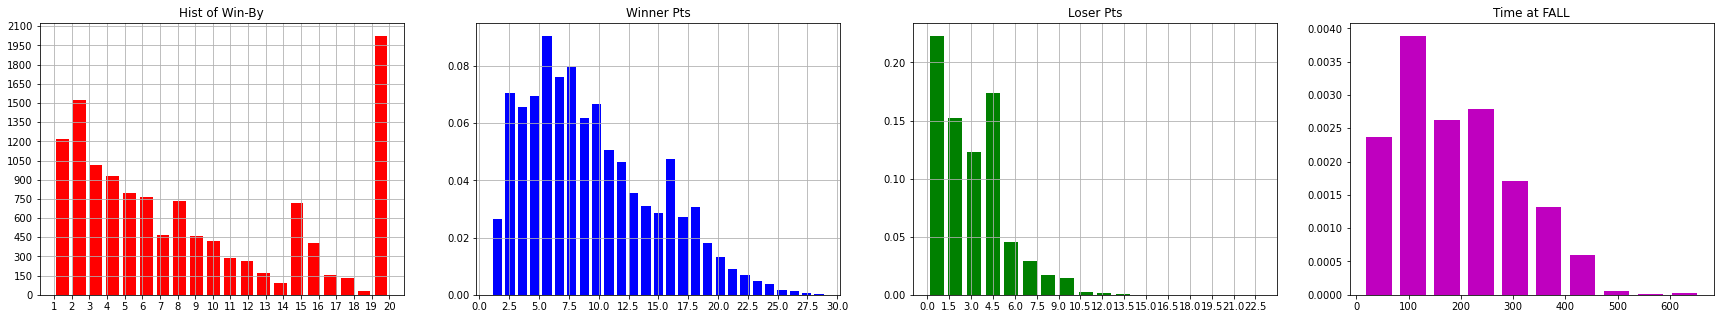

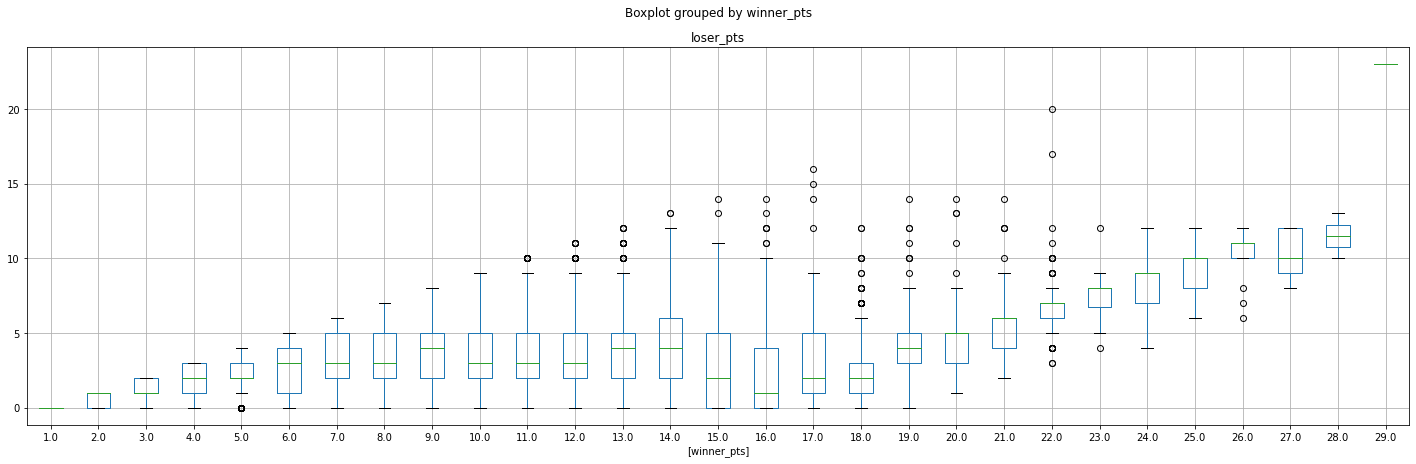

In [7]:
match_1 = (cln_wrest_data['by'] == 'FALL') 
match_2 = (cln_wrest_data['by'] == 'SV-1')
match_3 = (cln_wrest_data['by'] == 'TB-1') | (cln_wrest_data['by'] == 'TB-2') | (cln_wrest_data['by'] == 'SV-2') | (cln_wrest_data['by'] == 'TB-3') 

cln_wrest_data.loc[match_1,'score_diff'] = 20 #abs(elo_data_analysis.loc[match_1,'elo_diff']) / 4  #15 #(16*np.log10(abs(elo_data_analysis.loc[match_1,'elo_diff'])+18)-20)+5
#cln_wrest_data.loc[match_2,'score_diff'] = 0.5
#cln_wrest_data.loc[match_3,'score_diff'] = 0.25

plots, (fig_1a,fig_2a,fig_3a, fig_4a) = plt.subplots(1,4,figsize = (30,5));
#fig_1a.hist(cln_wrest_data['by'], density = True, color='#0504aa', alpha=0.7, rwidth=0.85);
#fig_1a.title.set_text('Hist of Win-By');
fig_1a.grid()
fig_1a.yaxis.set_major_locator(plt.MaxNLocator(15))
fig_1a.xaxis.set_major_locator(plt.MaxNLocator(21))
fig_1a.hist(cln_wrest_data['score_diff'].dropna(),  bins = 20, color = 'r',alpha = 1, rwidth = 0.75)
fig_1a.title.set_text('Hist of Win-By');
#fig_1a.xaxis.set_major_locator(plt.MaxNLocator(20))

fig_2a.grid()
fig_2a.hist(cln_wrest_data['winner_pts'] , density = True, bins = 27, color = 'b',alpha = 1, rwidth = 0.75);
fig_2a.title.set_text('Winner Pts');
fig_2a.xaxis.set_major_locator(plt.MaxNLocator(15))

fig_3a.grid()
fig_3a.hist(cln_wrest_data['loser_pts'], density = True,  bins = 18, color = 'g',alpha = 1, rwidth = 0.75);
fig_3a.title.set_text('Loser Pts');
fig_3a.xaxis.set_major_locator(plt.MaxNLocator(19))

fig_4a.hist(cln_wrest_data.loc[(cln_wrest_data['by'] == 'FALL'),'time'], density = True, color = 'm', alpha = 1,rwidth = 0.75);
fig_4a.title.set_text('Time at FALL');

boxplot = cln_wrest_data[['winner_pts','loser_pts']].boxplot(by = 'winner_pts',figsize = (24,7));
